Iniciando sistema de control...
ESP32 IP: 192.168.249.200


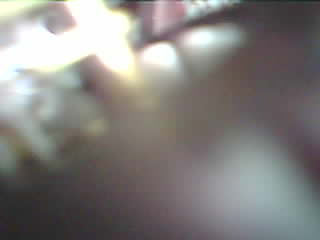

KeyboardInterrupt: 

In [ ]:
from decouple import config
from together import Together
import requests
import time
import base64
from io import BytesIO
import os

# Configuración
TOGETHER_API_KEY = config('TOGETHER_API_KEY')
ESP32_IP = "192.168.249.200"
CAPTURE_URL = f"http://{ESP32_IP}/capture"
COMMAND_URL = f"http://{ESP32_IP}/cmd"
INTERVAL = 1  # Intervalo en segundos entre capturas

"""Obtiene la dirección usando el modelo de IA y limpia la salida."""
prompt = """Analyze this image and determine the direction of the signal shown in it. 
The possible answers are: 'up', 'down', 'left', 'right', 'stop', or 'no signal'. 
If you are unsure or the image does not contain a signal, return only 'no signal'. 
Provide only the exact answer as a single word: 'up', 'down', 'left', 'right', 'stop', or 'no signal'. 
Do not include any explanations or additional text."""

    
# Etiquetas esperadas
valid_labels = {'up', 'down', 'left', 'right', 'stop', 'no signal'}

# Inicializar cliente Together
client = Together()

def capture_image_from_esp32():
    """Captura la imagen del ESP32-CAM y la convierte a base64"""
    try:
        response = requests.get(CAPTURE_URL, timeout=5)
        if response.status_code == 200:
            # Convertir la imagen a base64
            image_base64 = base64.b64encode(response.content).decode('utf-8')
            return f"data:image/jpeg;base64,{image_base64}"
        else:
            print(f"Error capturando imagen: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None

def send_command_to_esp32(command):
    """Envía el comando al ESP32"""
    try:
        response = requests.get(f"{COMMAND_URL}?cmd={command}", timeout=5)
        if response.status_code == 200:
            print(f"Comando enviado: {command}")
        else:
            print(f"Error enviando comando: {response.status_code}")
    except Exception as e:
        print(f"Error de conexión: {e}")

def get_direction(image_url): 
    try:
        response = client.chat.completions.create(
            model="meta-llama/Llama-3.2-70B-Vision-Instruct-Turbo",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": image_url,
                            },
                        },
                    ],
                }
            ]
        )
        # Limpia la respuesta del modelo
        raw_output = response.choices[0].message.content.strip().lower()  # Convertir a minúsculas y quitar espacios
        cleaned_output = raw_output.replace('"', '').replace("'", '')  # Quitar comillas si existen
        return cleaned_output if cleaned_output in valid_labels else "no signal"  # Validar contra etiquetas esperadas
    except Exception as e:
        print(f"Error en el procesamiento de IA: {e}")
        return "no signal"
    
def main():
    print("Iniciando sistema de control...")
    print(f"ESP32 IP: {ESP32_IP}")
    
    last_command = "stop"
    
    while True:
        # Capturar imagen
        image_url = capture_image_from_esp32()
        
        print(image_url)
        if image_url:
            # Procesar imagen
            direction = get_direction(image_url)
            print(f"Dirección detectada: {direction}")
            
            # Enviar comando si es diferente al último
            if direction != last_command:
                send_command_to_esp32(direction)
                last_command = direction
        
        # Esperar antes de la siguiente captura
        time.sleep(INTERVAL)

if __name__ == "__main__":
    main()